# 🧾 Preliminary Data Analysis – Brain2Action (Turning Brain Signals into Actions)


---


## 1. Introduction
This notebook performs a **preliminary data analysis (PDA)** of the BCI Competition IV Dataset 2b. The goal is to understand EEG data collected during *motor imagery (MI) tasks* and prepare for next steps: EDA and modeling.


---

## 2. Setup

In [141]:
# For now I am using forked mne-python for signal processing as community version has legacy-code bug.
# I already solved bug but it is currently under review. (ref: https://github.com/mne-tools/mne-python/issues/13414)


# I would recommand to install mne-python from my fork here:
# pip install git+https://github.com/devparikh0506/mne-python.git@fix-gdf-fromstring

In [140]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mne


# Set random seed for reproducibility
np.random.seed(42)

## 3. Dataset Overview
- **Source**: [BCI Competition IV Dataset 2b](https://www.bbci.de/competition/iv/)
- **Subjects**: 9
- **Tasks**: Motor Imagery (Left hand vs. Right hand)
- **Recording**: EEG at 250 Hz with multiple channels

## 4. Loading Data

In [128]:
raw = mne.io.read_raw_gdf("../data/BCICIV_2b_gdf/B0101T.gdf", preload=True)
events, event_dict = mne.events_from_annotations(raw)

event_id = {'Left': event_dict['769'], 'Right': event_dict['770']}
selected_events = events[np.isin(events[:, 2], list(event_id.values()))]  

raw.info['bads']
picks = mne.pick_types(raw.info, meg=False, eeg=True, eog=False, stim=False,
                exclude='bads')
epochs = mne.Epochs(raw, selected_events, event_id, picks=picks,tmin=0,tmax=3.996,preload=True,baseline=None)

Extracting EDF parameters from c:\Users\devdp\Github\UMBC\UMBC-DATA606-Capstone\data\BCICIV_2b_gdf\B0101T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
Creating raw.info structure...
Reading 0 ... 604802  =      0.000 ...  2419.208 secs...


C:\Users\devdp\AppData\Local\Temp\ipykernel_16396\1597401666.py:1: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_gdf("../data/BCICIV_2b_gdf/B0101T.gdf", preload=True)


Used Annotations descriptions: [np.str_('1023'), np.str_('1077'), np.str_('1078'), np.str_('1079'), np.str_('1081'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770')]
Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 120 events and 1000 original time points ...
0 bad epochs dropped


## 5. Converting to Tabular Format

In [134]:
data = epochs.get_data() # shape: (n_trials, n_channels, n_times)
times = epochs.times
labels = epochs.events[:, 2]


# Map numeric labels to text
label_map = {event_id['Left']: 'Left', event_id['Right']: 'Right'}
labels = [label_map[l] for l in labels]


# Convert to DataFrame
records = []
for trial_idx, trial_data in enumerate(data):
    for t_idx, t in enumerate(times):
        records.append({
        'trial_id': trial_idx,
        'time': round(float(t), 3),
        'EEG_C3': trial_data[0, t_idx],
        'EEG_Cz': trial_data[1, t_idx],
        'EEG_C4': trial_data[2, t_idx],
        'EOG_1': trial_data[3, t_idx],
        'EOG_2': trial_data[4, t_idx],
        'EOG_3': trial_data[5, t_idx],
        'label': labels[trial_idx]
        })


df = pd.DataFrame(records)
df.head()

,trial_id,time,EEG_C3,EEG_Cz,EEG_C4,EOG_1,EOG_2,EOG_3,label
0,0,0.000,-4.425116e-06,-3.680476e-06,0.000005,-0.000002,-0.000003,-2.441444e-07,Left
1,0,0.004,-3.628595e-06,-2.920577e-06,0.000006,0.000007,0.000006,9.857328e-06,Left
2,0,0.008,-2.337682e-06,-2.475013e-06,0.000006,0.000005,0.000010,4.303044e-06,Left
3,0,0.012,-3.601129e-06,-2.548257e-06,0.000007,0.000008,0.000016,1.553368e-05,Left
4,0,0.016,-7.782101e-07,-5.432212e-07,0.000005,0.000008,0.000014,1.000992e-05,Left


### 📚 Data Dictionary  

| Column / Variable | Data Type | Definition | Potential Values |
|-------------------|-----------|------------|------------------|
| `EEG_C3`          | Float     | EEG signal recorded at electrode C3 | Continuous values in µV |
| `EEG_Cz`          | Float     | EEG signal recorded at electrode Cz | Continuous values in µV |
| `EEG_C4`          | Float     | EEG signal recorded at electrode C4 | Continuous values in µV |
| `EOG_1`           | Float     | EOG signal (horizontal eye movement) | Continuous values in µV |
| `EOG_2`           | Float     | EOG signal (vertical eye movement) | Continuous values in µV |
| `EOG_3`           | Float     | EOG signal (eye rotation/blinks) | Continuous values in µV |
| `Label`           | String   | Motor imagery class label | Left, Right |
| `Trial_ID`        | Integer   | Unique trial identifier | e.g., 0-119 per subject |
| `Time`            | Float     | Time index of the signal (in seconds) | 0.0 – duration of trial |

---

### 🎯 Target Variable  
- **`Label`** → Binary classification task  
  - `left` = Left-hand motor imagery  
  - `right` = Right-hand motor imagery  

---

### 🔎 Feature Variables  
The following columns will be used as **features/predictors** for the ML model:  
- `EEG_C3`, `EEG_Cz`, `EEG_C4` (primary EEG channels of interest)  
- `Time` dimension (used for temporal modeling in CNNs/RNNs)  
- **Note**: EOG channels (`EOG_1`, `EOG_2`, `EOG_3`) are recorded for artifact removal but will **not** be used directly as features.  

---

## 6. Feature-level PDA:

TODO:
- Check **shape** of data (#trials, #samples, #channels)
- Verify **unique labels**
- Compute **summary statistics** (mean, std per channel)

In [143]:
print("Data Shape:", df.shape)
print('='*50)
print("Label distribution")
print('='*50)
print(df['label'].value_counts())
print('='*50)
print("Column Data Types:")
print('='*50)
print(df.dtypes)

Data Shape: (120000, 9)
Label distribution
label
Left     60000
Right    60000
Name: count, dtype: int64
Column Data Types:
trial_id      int64
time        float64
EEG_C3      float64
EEG_Cz      float64
EEG_C4      float64
EOG_1       float64
EOG_2       float64
EOG_3       float64
label        object
dtype: object


## 7. File metadata:

In [145]:
print('='*50)
print("File Info:")
print('='*50)
print(raw.info)
print('='*50)
print("Channels:", raw.ch_names)
print('='*50)
print("Events:",raw.annotations)
print('='*50)
print(f"Data duration: {raw.times[-1]//60} minutes")
print('='*50)

File Info:
<Info | 8 non-empty values
 bads: []
 ch_names: EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
 chs: 6 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: 2005-10-25 09:35:11 UTC
 nchan: 6
 projs: []
 sfreq: 250.0 Hz
 subject_info: <subject_info | his_id: B01, sex: 0, last_name: X, birthday: 1984-12-01>
>
Channels: ['EEG:C3', 'EEG:Cz', 'EEG:C4', 'EOG:ch01', 'EOG:ch02', 'EOG:ch03']
Events: <Annotations | 271 segments: 1023 (18), 1077 (1), 1078 (1), 1079 (1), 1081 ...>
Data duration: 40.0 minutes


## 8. Signal visualization.

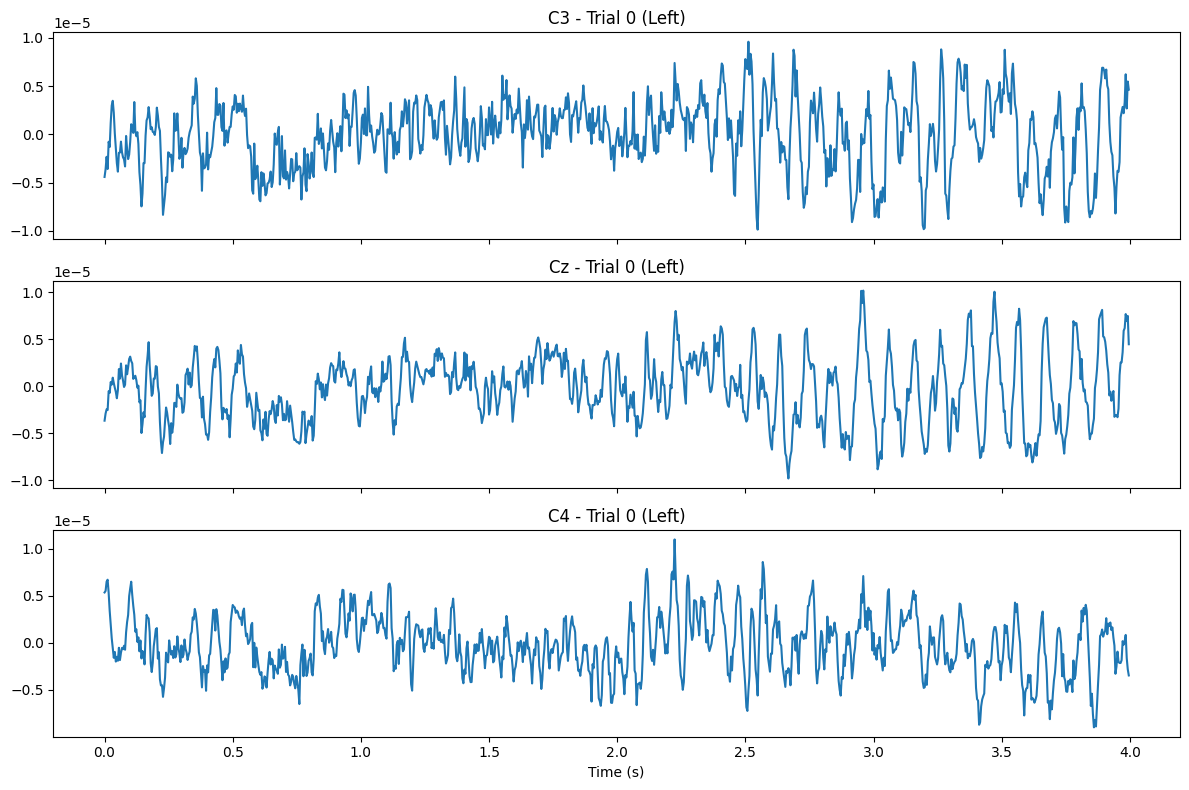

In [115]:
trial_to_plot = 0
trial_df = df[df['trial'] == trial_to_plot]


fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)


axes[0].plot(trial_df['time'], trial_df['C3'])
axes[0].set_title(f"C3 - Trial {trial_to_plot} ({trial_df['label'].iloc[0]})")


axes[1].plot(trial_df['time'], trial_df['Cz'])
axes[1].set_title(f"Cz - Trial {trial_to_plot} ({trial_df['label'].iloc[0]})")


axes[2].plot(trial_df['time'], trial_df['C4'])
axes[2].set_title(f"C4 - Trial {trial_to_plot} ({trial_df['label'].iloc[0]})")
axes[2].set_xlabel("Time (s)")


plt.tight_layout()
plt.show()

## 9. Next Steps
- Perform **Exploratory Data Analysis (EDA)** on the DataFrame (trial lengths, per-channel stats/variantions, amplitude spread accross frequencies).
- Apply **Preprocessing**:
    - Bandpass filter (8–30 Hz for motor imagery)
    - Noise removal (e.g., EOG/EMG artifacts)
    - Baseline removal / normalization

Above steps prepares cleaned data for feature extraction and modeling.